# Preprocess FaceID dataset

In [3]:
import os, sys, shutil, requests, zipfile, io
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm as pbar
from PIL import Image 
sys.path.insert(0, '/home/huy/Projects/FaceID')

In [4]:
data_dir = '/raid/data/pytorch_dataset/faceid/'

## 1. Download data

Dataset link
http://www.vap.aau.dk/rgb-d-face-database/

In [5]:
train_list=['http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(151751).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(153054).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(154211).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(160440).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(160931).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(161342).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(163349).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(164248).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(141550).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(142154).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(142457).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(143016).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(132824).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(133201).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(133846).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(134239).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(134757).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(140516).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(143345).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(144316).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(145150).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(145623).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(150303).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(150650).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(151337).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(151650).zip']

val_list=['http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(152717).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(153532).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(154129).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(154728).zip',
 'http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(155357).zip']

In [6]:
def get_data(links, directory):
    """
    Download and unzip data
    """
    for link in pbar(links):
        r = requests.get(link, stream=True)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(directory)

In [7]:
get_data(train_list, 'train_raw')
get_data(val_list, 'val_raw')

100%|██████████| 5/5 [01:54<00:00, 22.82s/it]


## 2. Process data

In [8]:
def process_data(raw_dir, processed_dir):
    """
    Stack RGB and D images to a tensor of shape 4 x 640 x 480
    Save images in format of personID_poseID  
    """
    all_people = [x for x in os.listdir(raw_dir) if '2012' in x]
    for person_id, a_person in enumerate(pbar(all_people)):
        
        all_poses = [x for x in os.listdir(os.path.join(raw_dir, a_person)) if '.bmp' in x]
        for pose_id, a_pose in enumerate(all_poses):
            photo_id = a_pose[:-5] # drop 'c.bmp'

            photo_rgb = photo_id + 'c.bmp'
            photo_rgb = Image.open(os.path.join(raw_dir, a_person, photo_rgb))
            photo_rgb = np.array(photo_rgb.convert("RGB").resize((640, 480)))
            photo_rgb = torch.from_numpy(photo_rgb).float()

            photo_depth = photo_id + 'd.dat'
            photo_depth = np.loadtxt(os.path.join(raw_dir, a_person, photo_depth))
            
            # Valid range is from 400 to 3000
            temp = np.copy(photo_depth)
            photo_depth = np.where((temp > 400) & (temp < 3000), temp, 0)
            
            photo_depth = torch.from_numpy(photo_depth).float()
            rgbd = torch.cat((photo_rgb, photo_depth.unsqueeze(-1)), -1)
            
            # PyTorch format is C x H x W
            rgbd = rgbd.permute(2, 0, 1)
            
            name = 'person' + str(person_id) + '_pose' + str(pose_id) + '.pt'
            torch.save(rgbd, os.path.join(processed_dir, name))

In [10]:
os.mkdir('train')
process_data('train_raw', 'train')

os.mkdir('val')
process_data('val_raw', 'val')

100%|██████████| 5/5 [01:12<00:00, 14.51s/it]


In [12]:
# Move data to desire place
# os.mkdir(data_dir)
shutil.move('train_raw', data_dir)
shutil.move('val_raw', data_dir)
shutil.move('train', data_dir)
shutil.move('val', data_dir)

'/raid/data/pytorch_dataset/faceid/val'

## 3. Display a test RGBD image

In [21]:
test_img_path = os.path.join(data_dir, 'train/person1_pose0.pt')
test_img = torch.load(test_img_path)
test_img = test_img.permute(1, 2, 0)

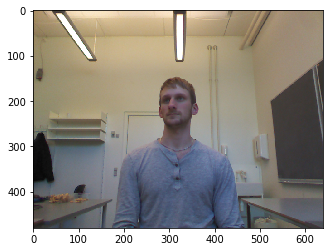

In [22]:
plt.imshow(test_img[:,:,:3]/255.0)
plt.show()

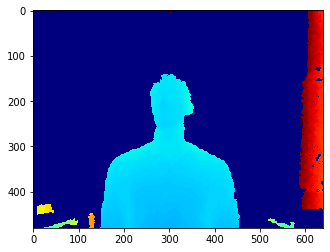

In [23]:
plt.imshow(test_img[:,:,-1], cmap='jet')
plt.show()